# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Root hydraulics

1. Root water uptake from a static soil 

2. Root hydraulic conductance (Krs)  

3. Standard uptake fraction (SUF)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import plantbox as pb
import visualisation.vtk_plot as vp
from functional.PlantHydraulicModel import (
    HydraulicModel_Doussan,
    HydraulicModel_Meunier,
)
from functional.PlantHydraulicParameters import PlantHydraulicParameters

sourcedir = "/home/jhack/phd/CPlantBox/"

In [ ]:
def get_1d_from_3d_suf(hm: HydraulicModel_Meunier | HydraulicModel_Doussan, suf: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Convert 3D SUF (Standard Uptake Fraction) data to 1D depth profile for given hydraulic model and SUF values at each segment.
    
    Args:
        hm: Hydraulic model instance (either Meunier or Doussan); contains the mapped segments.
        suf: Array of SUF values at each segment in the 3D root structure.

    Returns:
        suf_array: 1D array of SUF values averaged over horizontal layers.
        depth_array: Corresponding depth midpoints for the SUF values [cm].

    Notes:
        The function bins the root system along the z-axis (soil depth) with 5 cm layers (bin size hardcoded in function) 
        and computes the total SUF in each layer.
    """
    ana = pb.SegmentAnalyser(hm.ms)
    ana.addData("SUF", suf)  # suf at each segment in the 3d space
    
    bin_size = 5  # soil layer thickness is defined, for plotting purposes
    z_max = 0
    z_min = -150
    n_bins = int((z_max - z_min) / bin_size)
    suf_dist = ana.distribution("SUF", z_max, z_min, n_bins, True) 
    
    depths = np.linspace(z_max - bin_size / 2, z_min + bin_size / 2, n_bins)  
    suf_array = np.array(suf_dist)
    depth_array = np.array(depths)
    return suf_array, depth_array

def get_variables_for_suf(hm: HydraulicModel_Meunier | HydraulicModel_Doussan, time: float | int) -> np.ndarray:
    """
    Compute radial flux (water uptake) for each segment at a given simulation time using a hydraulic model.

    Args:
        hm: Hydraulic model instance (either Meunier or Doussan); contains the mapped segments
        time: Current simulation time [day]

    Returns:
        q: Array of radial fluxes for each segment [(cm3/cm2)/day]

    Notes:
        - assumes uniform soil potential (-500 cm); hardcoded in function.
        - applies a Dirichlet boundary condition at the root collar with a fixed potential of -15000 cm; hardcoded in function.
    """
    n = hm.ms.getNumberOfMappedSegments()
    rsx = np.ones((n, 1)) * (-500)
    rsx = hm.ms.total2matric(rsx)
    rx = hm.solve_dirichlet(time, -15000, rsx, cells = False)
    q = hm.radial_fluxes(time, rx, rsx)
    return np.array(q)

def sinusoidal2(t: int | float, dt: int | float) -> np.ndarray:
    """ 
    Sinusoidal function from 6:00 - 18:00, 0 otherwise (used for transpiration, integral over one day is 1). 
    Defines time-dependent factor between 0 and ~1 that is later multiplied with potential transpiration rate to obtain actual transpiration rate at time t.

    Args:
        t: current simulation time
        dt: time step
    """
    return np.maximum(0., np.pi * (np.cos(2 * np.pi * (t - 0.5)) + np.cos(2 * np.pi * ((t + dt) - 0.5))) / 2)

### Root water uptake from a static soil 

Water flow in the hydraulic tree is computed according to the xylem water potential gradients between nodes, driven by the boundary condition at the root collar. At the root collar, either the water potential or the water flux can be prescribed (Dirichlet or Neumann boundary conditions). Root water uptake is computed as the sum of the radial fluxes into each root segment, according the the water potential differences between xylem and soil. 
In the example below, we set a constant and uniform total soil water potential, and constant root hydraulic properties. 

MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Root collar potential -1000 [cm], transpiration -18.9902 [cm3/day]
added radial flux


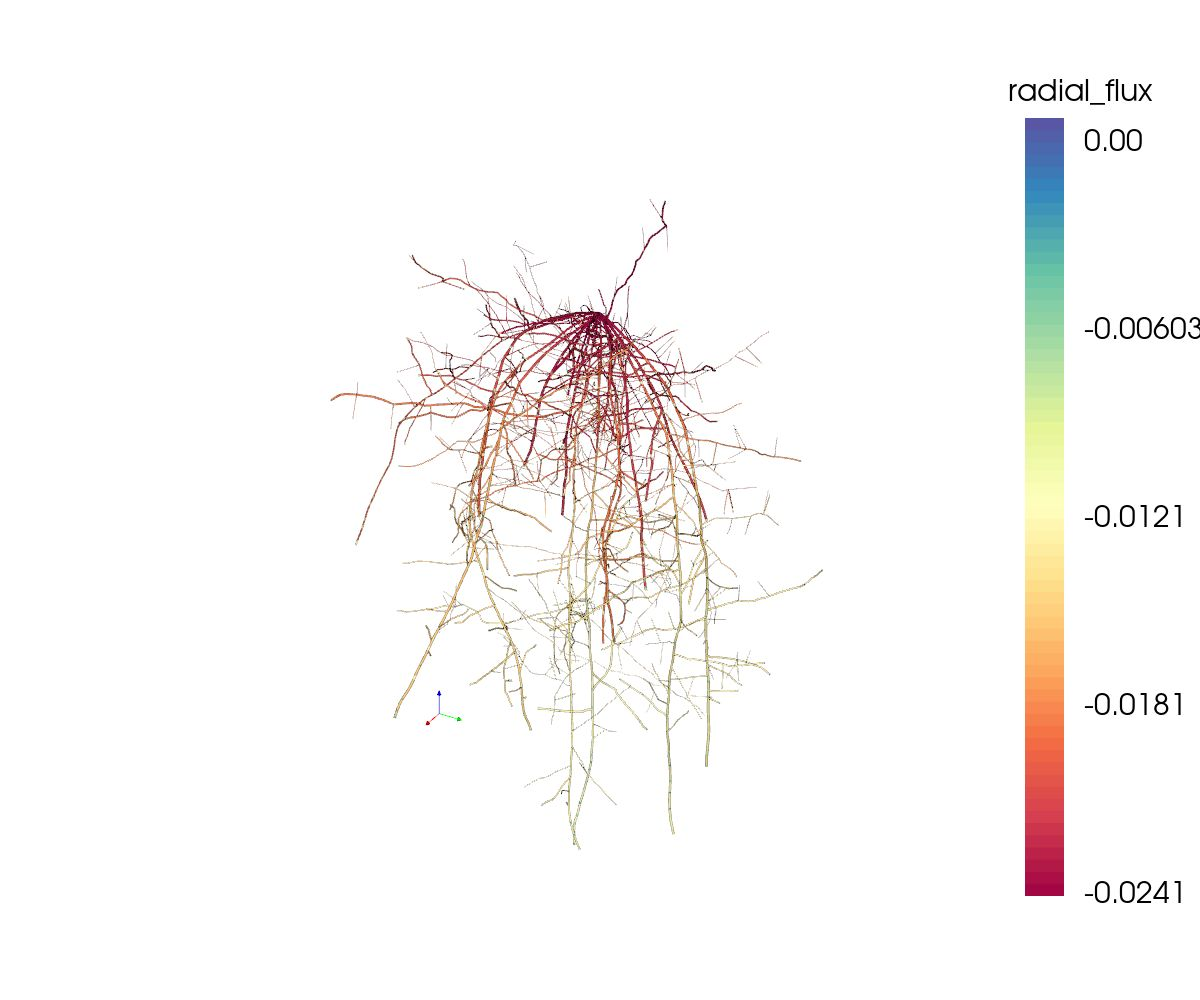

writing VTP: restuls/example4_1_roothydraulics.vtp


In [ ]:
""" Parameters """  # 
initial_age = 14  # root system age [day]
kx = 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]
Hs = -300  # soil total potential [cm]
h0 = -1000  # dirichlet boundary condition at top [cm]; fixed potential at root collar
#h0 = None  # neumann boundary condition at top [cm]; fixed flux at root collar
t_pot = -10  # potential plant transpiration [cm3/day] --> neuman bc of fixed flux

""" root system """  
plant = pb.MappedPlant() # plant model with mapping --> links 3D root structure to soil grid
path = sourcedir + "modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI"
plant.readParameters(path + name + ".xml")
plant.initialize()
plant.simulate(initial_age)  

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.set_kr_const(kr)
params.set_kx_const(kx)
hm = HydraulicModel_Doussan(plant, params) # network solver treating rs as electrical circuit
#hm = HydraulicModel_Meunier(plant, params) # simpler 1D analytical formulation

""" Numerical solution """ 
ns = plant.getNumberOfMappedSegments()
hsr = plant.total2matric(Hs * np.ones((ns,))) # soil-root interface potential [cm] 
hx = hm.solve_dirichlet(initial_age, h0, hsr, cells = False) # dirichlet boundary condition of fixed potential at root collar
print(f"Root collar potential {hx[0]:g} [cm], transpiration {hm.get_transpiration(initial_age, hx, hsr):g} [cm3/day]")
# hx0: potential at topmost node aka collar; hx: xylem potential [cm]; hm: resulting total flux (actual transpiration) [cm3/day]
hx = hm.solve_neumann(initial_age, t_pot, hsr, cells = False) # bc of fixed flux at root collar --> computes potential at collar
print(f"Root collar potential {hx[0]:g} [cm], transpiration {hm.get_transpiration(initial_age, hx, hsr):g} [cm3/day]")

""" Additional vtk plot """
ana = pb.SegmentAnalyser(hm.ms.mappedSegments())  
ana.addData("hx", hx)  # xylem potentials [cm]
ana.addData("SUF", hm.get_suf(initial_age))  # standard uptake fraction [1]
ana.addAge(initial_age)  # age [day] 
ana.addHydraulicConductivities(params, initial_age)  # kr [1/day], kx [cm3/day] ;set before as params
ana.addFluxes(hm, hx, hsr, initial_age)  # "axial_flux" [cm3/day], "radial_flux" [ (cm3/cm2) / day] 
vp.plot_plant(ana, "radial_flux", interactiveImage = False)  

""" output for paraview """
ana.write("restuls/example4_1_roothydraulics.vtp",  
          types = ["radius", "subType", "age", "hx", "SUF", "kr", "kx", "axial_flux", "radial_flux"])


Potential transpiration

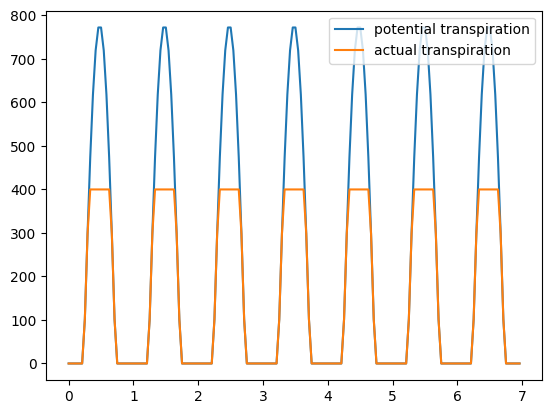

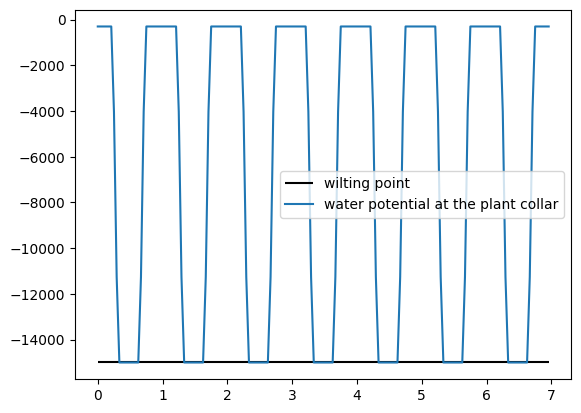

In [ ]:
""" Parameters """  
sim_time = 7 #[day]
dt = 3600./(24.*3600) # time steps here 1 hour [day]
initial_age = 14  # root system age [day]
kx = 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]
Hs = -300  # soil total potential [cm]
t_pot = -250  # potential plant transpiration per day [cm3/day] 

""" root system """  
plant = pb.MappedPlant()  
path = sourcedir + "modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI"
plant.readParameters(path + name + ".xml")
plant.initialize(False) # do not set up mapping yet; handled in hydraulic model
plant.simulate(initial_age)  

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.set_kr_const(kr)
params.set_kx_const(kx)
hm = HydraulicModel_Doussan(plant, params)  

""" Simulation loop """ 
ns = plant.getNumberOfMappedSegments()
hsr = plant.total2matric(Hs * np.ones((ns,)))  # static uniform total soil potential

N = int(sim_time/dt) # calculate number of time steps
h_collar_ = []
t_act_ = []
for i in range(0, N):
    t = i*dt # current simulation time 
    rx = hm.solve(initial_age, t_pot*sinusoidal2(t,dt), hsr, cells = False) # return vector of xylem potentials [cm] at all nodes
    t_act = hm.get_transpiration(sim_time, rx, hsr, cells = False) # return actual transpiration [cm3/day] given xylem and soil potentials
    t_act_.append(t_act) # store actual transpiration
    h_collar_.append(rx[hm.collar_index_]) # store potential at root collar

t = np.linspace(0, (N-1)*dt, N)
plt.plot(t, -t_pot*sinusoidal2(t,dt), label = "potential transpiration")
plt.plot(t, -np.array(t_act_), label = "actual transpiration")
plt.legend()
plt.show()
plt.hlines(hm.wilting_point,xmin = t[0],xmax=t[-1], label = "wilting point",colors='k')
plt.plot(t, h_collar_, label = "water potential at the plant collar")
plt.legend()
plt.show()

Age dependent conductivities

0.357
0.00411

SubType 0 for negative age: kx = 0.0001, kr = 0.0001
SubType 0 for old root age: kx = 0.0001, kr = 0.0001
SubType 1 for negative age: kx = 0.0674, kr = 0.00114
SubType 1 for old root age: kx = 0.357, kr = 0.000517
SubType 2 for negative age: kx = 0.000407, kr = 0.00411
SubType 2 for old root age: kx = 0.0136, kr = 0.00158
SubType 3 for negative age: kx = 0.000407, kr = 0.00411
SubType 3 for old root age: kx = 0.0136, kr = 0.00158
SubType 4 for negative age: kx = 0.0674, kr = 0.00114
SubType 4 for old root age: kx = 0.357, kr = 0.000517



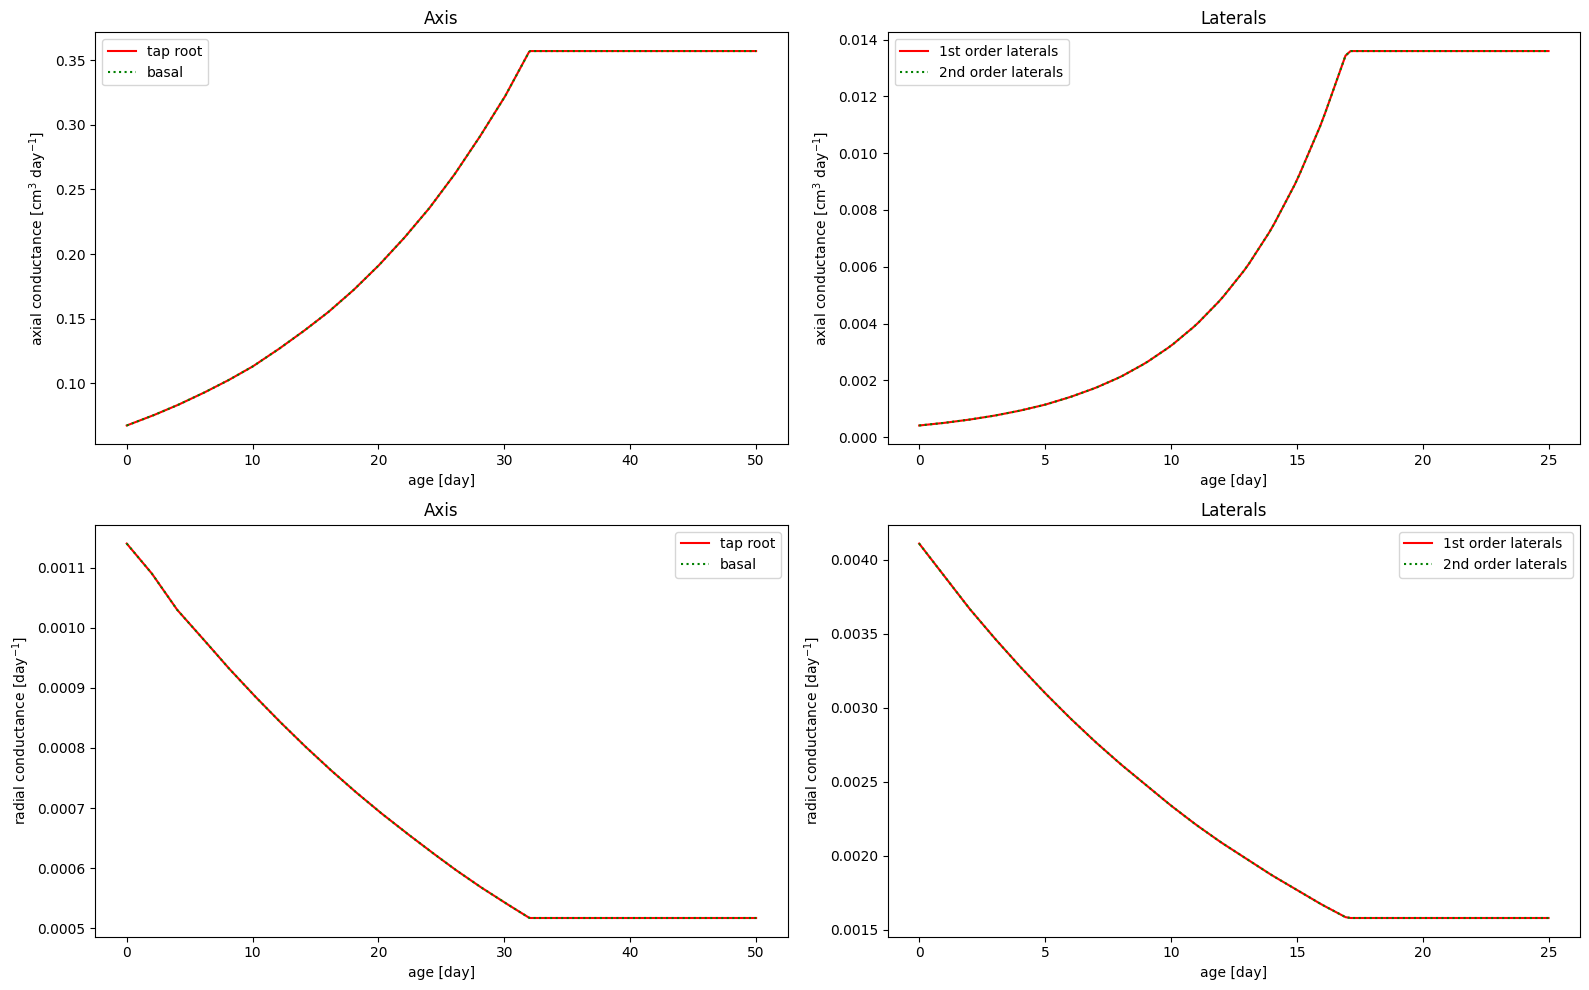

In [ ]:
param = PlantHydraulicParameters()
# [age in day, conductivity]
kr0 = np.array([[0, 1.14e-03], [2, 1.09e-03], [4, 1.03e-03], [6, 9.83e-04], [8, 9.35e-04], [10, 8.90e-04], [12, 8.47e-04], [14, 8.06e-04], [16, 7.67e-04], [18, 7.30e-04], [20, 6.95e-04], [22, 6.62e-04], [24, 6.30e-04], [26, 5.99e-04], [28, 5.70e-04], [30, 5.43e-04], [32, 5.17e-04]])
kr1 = np.array([[0, 4.11e-03], [1, 3.89e-03], [2, 3.67e-03], [3, 3.47e-03], [4, 3.28e-03], [5, 3.10e-03], [6, 2.93e-03], [7, 2.77e-03], [8, 2.62e-03], [9, 2.48e-03], [10, 2.34e-03], [11, 2.21e-03], [12, 2.09e-03], [13, 1.98e-03], [14, 1.87e-03], [15, 1.77e-03], [16, 1.67e-03], [17, 1.58e-03]])
param.set_kr_age_dependent(kr0[:, 0], kr0[:, 1], subType = [1,4])
param.set_kr_age_dependent(kr1[:, 0], kr1[:, 1], subType = [2, 3])

kx0 = np.array([[0, 6.74e-02], [2, 7.48e-02], [4, 8.30e-02], [6, 9.21e-02], [8, 1.02e-01], [10, 1.13e-01], [12, 1.26e-01], [14, 1.40e-01], [16, 1.55e-01], [18, 1.72e-01], [20, 1.91e-01], [22, 2.12e-01], [24, 2.35e-01], [26, 2.61e-01], [28, 2.90e-01], [30, 3.21e-01], [32, 3.57e-01]])
kx1 = np.array([[0, 4.07e-04], [1, 5.00e-04], [2, 6.15e-04], [3, 7.56e-04], [4, 9.30e-04], [5, 1.14e-03], [6, 1.41e-03], [7, 1.73e-03], [8, 2.12e-03], [9, 2.61e-03], [10, 3.21e-03], [11, 3.95e-03], [12, 4.86e-03], [13, 5.97e-03], [14, 7.34e-03], [15, 9.03e-03], [16, 1.11e-02], [17, 1.36e-02]])
param.set_kx_age_dependent(kx0[:, 0], kx0[:, 1], subType = [1,4]) # set age and conductivity for subType 1 and 4
param.set_kx_age_dependent(kx1[:, 0], kx1[:, 1], subType = [2, 3])

_ = param.plot_conductivities(axes_ind = [1,4], lateral_ind = [2, 3])

### Root hydraulic conductance (Krs) 

Root system conductance (Krs) for different root architectures over time: 


Simulating: Heliantus_Pagès_2013


/home/jhack/phd/cpbenv/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])



Simulating: Glycine_max_Moraes2020_opt2

Simulating: Brassica_oleracea_Vansteenkiste_2014

Simulating: Zea_mays_1_Leitner_2010


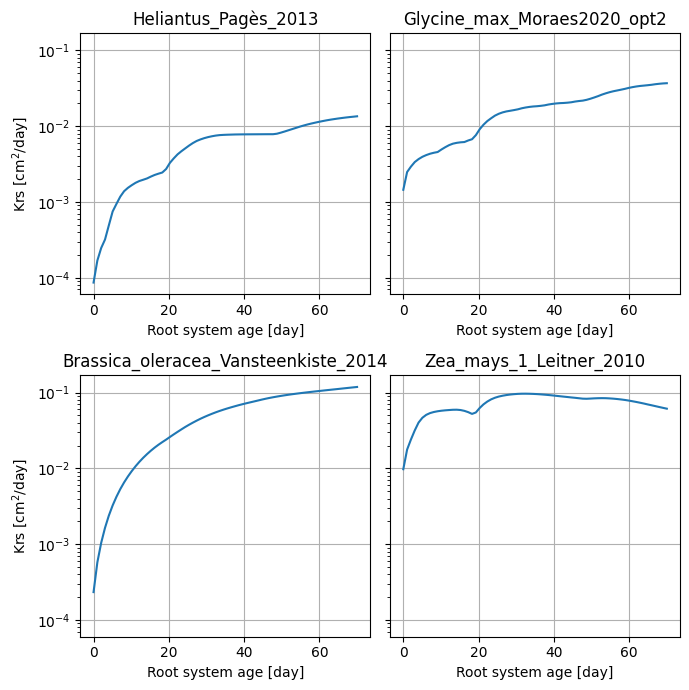


Summary:
Heliantus_Pagès_2013 | Total root length: 15039.62 cm | Surface area:  1019.61 cm2
Glycine_max_Moraes2020_opt2 | Total root length:  8587.32 cm | Surface area:  1670.37 cm2
Brassica_oleracea_Vansteenkiste_2014 | Total root length: 27631.91 cm | Surface area:  2388.94 cm2
Zea_mays_1_Leitner_2010 | Total root length: 10842.04 cm | Surface area:  2035.45 cm2


In [6]:
sim_time = 70 # [day]
dt = 1 # [day]

architectures = [  
    "Heliantus_Pagès_2013",
    "Glycine_max_Moraes2020_opt2",
    "Brassica_oleracea_Vansteenkiste_2014",
    "Zea_mays_1_Leitner_2010"
]

path = sourcedir + "modelparameter/structural/rootsystem/"  

""" Root hydraulic properties """  
param = PlantHydraulicParameters()

kr0 = np.array([[0., 2.2e-4], [12.5, 2.2e-4], [20.9, 8.0e-5], [44.6, 8.0e-5], [62.7, 1.9e-5], [100, 1.9e-5]]) # [age in days, radial conductivity in 1/day]
kr1 = np.array([[0., 1.8e-4], [10, 1.8e-4], [15, 1.7e-5], [25, 1.7e-5]])
param.set_kr_age_dependent(kr0[:, 0], kr0[:, 1], subType = [1, 4])  
param.set_kr_age_dependent(kr1[:, 0], kr1[:, 1], subType = [2, 3])

kx0 = np.array([[0, 2.7e-2], [18.3, 2.7e-2], [21, 3.3e-1], [47, 3.3e-1], [61, 4.2], [100, 4.2]]) # [age in days, axial conductivity in cm3/day]
kx1 = np.array([[0, 1.e-4], [9, 2.e-4], [13, 6.e-4], [20, 1.73e-3], [25, 1.73e-3]])
param.set_kx_age_dependent(kx0[:, 0], kx0[:, 1], subType = [1, 4])
param.set_kx_age_dependent(kx1[:, 0], kx1[:, 1], subType = [2, 3]) 

""" Simulation loop""" 
krs_all, lengths, surfaces  = [], [], []

for name in architectures:
    print(f"\nSimulating: {name}")

    plant = pb.MappedPlant()  
    plant.readParameters(path + name + ".xml")
    plant.initialize(False)

    hm = HydraulicModel_Meunier(plant, param) # simplified analytical solver; new hydraulic model created for each architecture
    krs_values = []
    arch_lengths = []
    arch_surfaces = []
    N = int(sim_time/dt) # calculate number of time steps
    for i in range(0, N):
        plant.simulate(dt) # simulate growth for one time step (here 1 day)
        krs, _ = hm.get_krs(i*dt) # get root system conductance at current age
        krs_values.append(krs)
        total_length = np.sum(np.array(plant.getParameter("length"))) # sum lengths of all segments for total root length
        total_surface = np.sum(np.array(plant.getParameter("surface"))) # sum surfaces of all segments for total root surface
        arch_lengths.append(total_length)
        arch_surfaces.append(total_surface)        

    krs_all.append(krs_values) # list of lists; each sublist contains krs values over time for one architecture
    lengths.append(arch_lengths[-1])  # final length
    surfaces.append(arch_surfaces[-1])  # final surface 

""" Plot """  
fig, axes = plt.subplots(2, 2, figsize = (7,7), sharey = True)
for i, ax in enumerate(axes.flat):
    ax.plot(np.linspace(0, sim_time,N), krs_all[i])
    ax.set_title(architectures[i])
    ax.set_xlabel("Root system age [day]")
    ax.set_yscale("log") # logarithmic scale for conductances
    if i%2 == 0:
        ax.set_ylabel("Krs [cm$^2$/day]")
    ax.grid(True)
plt.tight_layout()
plt.show()  

print("\nSummary:")
for i, name in enumerate(architectures):
    print(f"{name:20s} | Total root length: {lengths[i]:8.2f} cm | Surface area: {surfaces[i]:8.2f} cm2")

In [ ]:
sim_time = 70 #[day]
name = "Zea_mays_1_Leitner_2010"
path = sourcedir + "modelparameter/structural/rootsystem/"  

""" Root hydraulic properties """  # here age dependent
param = PlantHydraulicParameters()

kr0 = np.array([[0., 2.2e-4], [12.5, 2.2e-4], [20.9, 8.0e-5], [44.6, 8.0e-5], [62.7, 1.9e-5], [100, 1.9e-5]])
kr1 = np.array([[0., 1.8e-4], [10, 1.8e-4], [15, 1.7e-5], [25, 1.7e-5]])
param.set_kr_age_dependent(kr0[:, 0], kr0[:, 1], subType = [1, 4])  
param.set_kr_age_dependent(kr1[:, 0], kr1[:, 1], subType = [2, 3])

kx0 = np.array([[0, 2.7e-2], [18.3, 2.7e-2], [21, 3.3e-1], [47, 3.3e-1], [61, 4.2], [100, 4.2]])
kx1 = np.array([[0, 1.e-4], [9, 2.e-4], [13, 6.e-4], [20, 1.73e-3], [25, 1.73e-3]])
param.set_kx_age_dependent(kx0[:, 0], kx0[:, 1], subType = [1, 4])
param.set_kx_age_dependent(kx1[:, 0], kx1[:, 1], subType = [2, 3]) 


plant = pb.MappedPlant(1)  
plant.readParameters(path + name + ".xml")
plant.initialize(False)

hm = HydraulicModel_Meunier(plant, param) 
plant.simulate(sim_time) 
krs, _ = hm.get_krs( sim_time)
print("Krs [cm2/day]:",krs) 


hs_total = -200 # total soil potential [cm]
hsx_total = np.ones((hm.ms.getNumberOfMappedSegments(), 1)) * (hs_total) # total soil potential at all segments
suf = hm.get_suf(sim_time) # standard uptake fraction at current age
heff = suf.dot(hsx_total)[0] # effective soil potential
hx = hm.solve_dirichlet(sim_time, -15000, hm.ms.total2matric(hsx_total), cells = False) # hydraulic head
t_act = -hm.get_transpiration(sim_time, hx, hm.ms.total2matric(hsx_total), cells = False) # actual transpiration
hx_collar = hx[hm.collar_index()] # potential at root collar
Krs = t_act / (heff - hx_collar)
print("Krs [cm2/day]:",Krs)

/home/jhack/phd/cpbenv/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Krs [cm2/day]: 0.10096350073178517


/tmp/ipykernel_289155/3319310919.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hx = hm.solve_dirichlet(sim_time, -15000, hm.ms.total2matric(hsx_total), cells = False) # hydraulic head


Krs [cm2/day]: 0.1009839468665587


/tmp/ipykernel_289155/3319310919.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_act = -hm.get_transpiration(sim_time, hx, hm.ms.total2matric(hsx_total), cells = False) # actual transpiration


### Standard uptake fraction (SUF)


Simulating: Heliantus_Pagès_2013
MappedPlant::initializeLB 
Seed::initialize: RootSystem 

Simulating: Glycine_max_Moraes2020_opt2


/home/jhack/phd/cpbenv/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


MappedPlant::initializeLB 
Seed::initialize: RootSystem 

Simulating: Brassica_oleracea_Vansteenkiste_2014
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead

Simulating: Zea_mays_1_Leitner_2010
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead


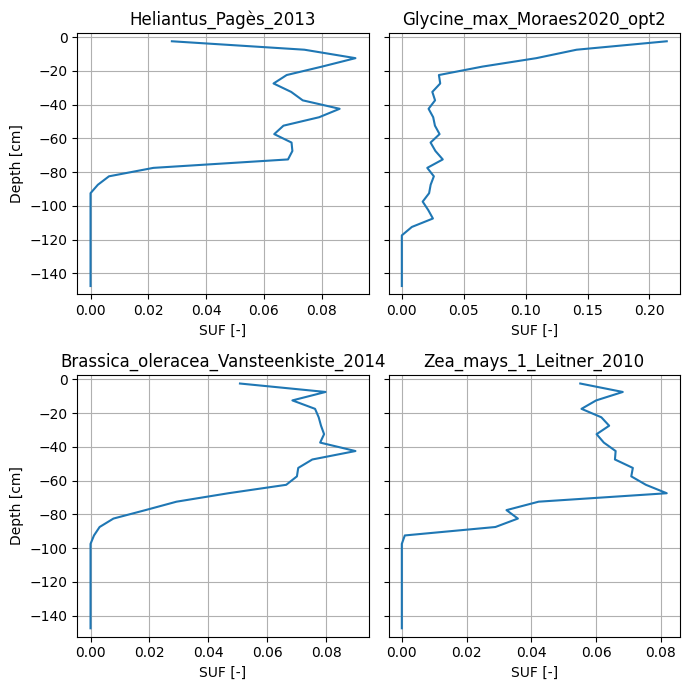

In [10]:
""" Simulation loop""" 
suf_profiles = [] # To store SUF depth profiles for all architectures at final sim_time

for name in architectures:
    print(f"\nSimulating: {name}")

    plant = pb.MappedPlant()  
    plant.readParameters(path + name + ".xml")
    plant.initialize() # not set to False; mapping needed for SUF calculation but not necessarily done by hydraulic model
    hm = HydraulicModel_Meunier(plant, param)  # param from example before
    plant.simulate(sim_time)

    suf = hm.get_suf(sim_time) # standard uptake fraction at current age; depends on kx, kr & topology
    ana = pb.SegmentAnalyser(plant)
    ana.addData("SUF", suf)  # suf at each segment in the 3d space; enabled through SegmentAnalyser

    bin_size = 5  # soil layer thickness is defined (= depth resolution), for plotting purposes
    z_max = 0
    z_min = -150
    n_bins = int((z_max - z_min) / bin_size) # number of soil layers
    suf_dist = ana.distribution("SUF", z_max, z_min, n_bins, True) # params: data name, zmax, zmin, n_bins, normalize

    depths = np.linspace(z_max - bin_size / 2, z_min + bin_size / 2, n_bins) # mid points of soil layers
    suf_array = np.array(suf_dist) # array of SUF values for each soil layer
    depth_array = np.array(depths) # array of depth values for each soil layer
    
    suf_profiles.append((suf_array, depth_array)) # for plotting

""" Plotting """
fig_suf, axes_suf = plt.subplots(2, 2, figsize = (7,7), sharey = True)  

for i, ax in enumerate(axes_suf.flat):
    suf, depth = suf_profiles[i]
    ax.plot(suf, depth)
    ax.set_xlabel("SUF [-]")
    if i % 2 == 0:
        ax.set_ylabel("Depth [cm]")
    ax.grid(True)
    ax.set_title(architectures[i])
    if len(depth) > 0:
        ax.set_ylim(depth.min() - 5, depth.max() + 5)  # optional padding

plt.tight_layout()
plt.show()  

/home/jhack/phd/cpbenv/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


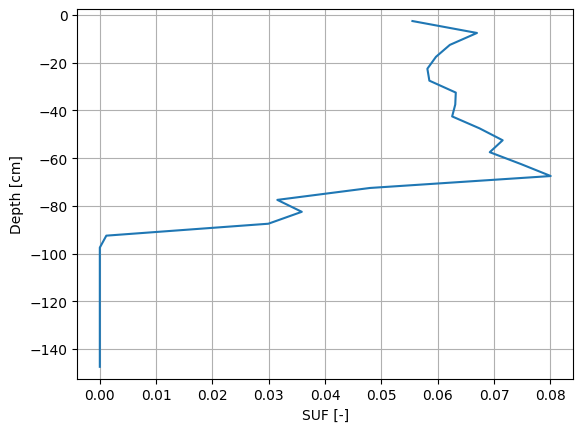

/tmp/ipykernel_289155/903654256.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rsx = hm.ms.total2matric(rsx)


'\nsuf_3d = ?\nsuf_array, depth_array = get_1d_from_3d_suf(hm, suf_3d)\nplt.plot(suf_array, depth_array)\nplt.xlabel("SUF [-]")\nplt.ylabel("Depth [cm]")\nplt.grid(True)\nplt.ylim(depth_array.min() - 5, depth_array.max() + 5)  # optional padding\nplt.show()  \n'

In [ ]:
sim_time = 70  
name = "Zea_mays_1_Leitner_2010"
path = sourcedir + "modelparameter/structural/rootsystem/"  

""" Root hydraulic properties """  
param = PlantHydraulicParameters()

kr0 = np.array([[0., 2.2e-4], [12.5, 2.2e-4], [20.9, 8.0e-5], [44.6, 8.0e-5], [62.7, 1.9e-5], [100, 1.9e-5]])
kr1 = np.array([[0., 1.8e-4], [10, 1.8e-4], [15, 1.7e-5], [25, 1.7e-5]])
param.set_kr_age_dependent(kr0[:, 0], kr0[:, 1], subType = [1, 4])  
param.set_kr_age_dependent(kr1[:, 0], kr1[:, 1], subType = [2, 3])

kx0 = np.array([[0, 2.7e-2], [18.3, 2.7e-2], [21, 3.3e-1], [47, 3.3e-1], [61, 4.2], [100, 4.2]])
kx1 = np.array([[0, 1.e-4], [9, 2.e-4], [13, 6.e-4], [20, 1.73e-3], [25, 1.73e-3]])
param.set_kx_age_dependent(kx0[:, 0], kx0[:, 1], subType = [1, 4])
param.set_kx_age_dependent(kx1[:, 0], kx1[:, 1], subType = [2, 3]) 


plant = pb.MappedPlant(1)  
plant.readParameters(path + name + ".xml")
plant.initialize(False)

hm = HydraulicModel_Meunier(plant, param) 
plant.simulate(sim_time) 
    
suf_3d = hm.get_suf(sim_time)
suf_array, depth_array = get_1d_from_3d_suf(hm, suf_3d)

plt.plot(suf_array, depth_array)
plt.xlabel("SUF [-]")
plt.ylabel("Depth [cm]")
plt.grid(True)
plt.ylim(depth_array.min() - 5, depth_array.max() + 5)  # optional padding
plt.show()  

radial_fluxes = get_variables_for_suf(hm, sim_time)

# Group Excercises
Change the plant parameters according to the input parameters given for each group. How do the parameters affect the hydraulic structure of the resulting root system?

subtype 0 is undefined
subtype 1 is taproot
subtype 2 is lateral
subtype 3 is tertiaryroots
subtype 4 is basal
subtype 5 is shootborne
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 


/home/jhack/phd/cpbenv/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


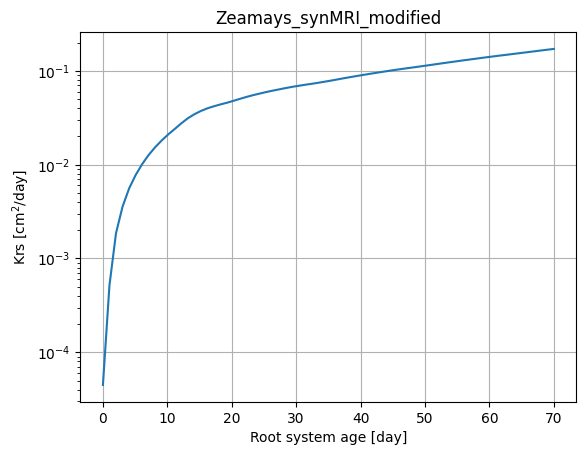

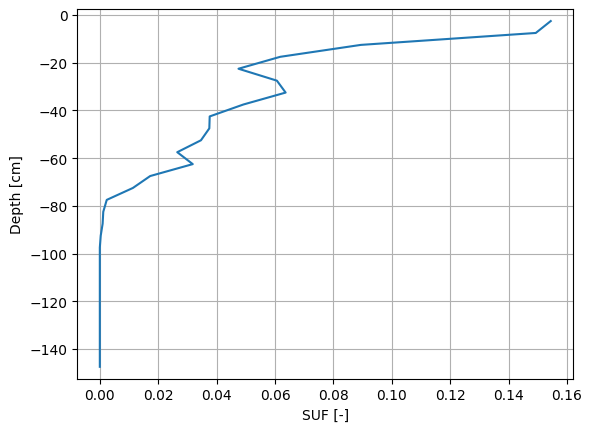


Summary:
Zeamays_synMRI_modified | Total root length: 28787.15 cm | Surface area:  4032.70 cm2


In [ ]:
sim_time = 70  
dt = 1

name = "Zeamays_synMRI_modified" 
path = sourcedir + "modelparameter/structural/rootsystem/"  

""" Root hydraulic properties """  
param = PlantHydraulicParameters()

kr0_max = 0.000008 # other value: 0.000125
kr1_max = 0.0005 # other value: 0.0002
kx0_max = 8.2 # other value: 1
kx1_max = 0.017 # other value: 0.0017
 
kr0 = np.array([[0., kr0_max], [12.5, kr0_max], [20.9, kr0_max/2], [44.6, kr0_max/2], [62.7, kr0_max/10], [100, kr0_max/10]])
kr1 = np.array([[0., kr1_max], [10, kr1_max], [15, kr1_max/10], [25, kr1_max/10]])
param.set_kr_age_dependent(kr0[:, 0], kr0[:, 1], subType = [1, 4, 5])  
param.set_kr_age_dependent(kr1[:, 0], kr1[:, 1], subType = [2, 3])


kx0 = np.array([[0, kx0_max/200.], [18.3, kx0_max/200.], [21, kx0_max/10.], [47, kx0_max/10.], [61, kx0_max], [100, kx0_max]])
kx1 = np.array([[0, kx1_max/200.], [9, kx1_max/100.], [13, kx1_max/4], [20, kx1_max], [25, kx1_max]])
param.set_kx_age_dependent(kx0[:, 0], kx0[:, 1], subType = [1, 4, 5])
param.set_kx_age_dependent(kx1[:, 0], kx1[:, 1], subType = [2, 3]) 

""" Simulation loop""" 
plant = pb.MappedPlant()  
plant.readParameters(path + name + ".xml")


for p in plant.getOrganRandomParameter(pb.root):
    print(f"subtype {p.subType} is {p.name}")
    if (p.subType == 1):
        p.r = 2 # radius [cm], other value: 1.2
        p.ln = 1.7 # interlateral distance [cm], other value: 0.69
        p.lmax = 165 # maximal length [cm], other value: 135
        p.tropismS = 0.3 # tropism strength, other value: 0.15
        pass
    if (p.subType == 4):
        p.r = 2 # radius [cm], other value: 1.2
        p.ln = 0.71 # interlateral distance [cm], other value: 0.28
        p.lmax = 165 # maximal length [cm], other value: 135
        p.tropismS = 0.3 # tropism strength, other value: 0.15
        p.theta = 0.74 # insertion angle [rad], other value: 1.85
        pass
    if (p.subType == 5):
        p.r = 2 # radius [cm], other value: 1.2
        p.ln = 0.71 # interlateral distance [cm], other value: 0.28
        p.lmax = 165 # maximal length [cm], other value: 135
        pass

plant.initialize(False)

hm = HydraulicModel_Meunier(plant, param) 
krs_values = []
arch_lengths = []
arch_surfaces = []
N = int(sim_time/dt)

for i in range(0, N):
    plant.simulate(dt)    
    krs, _ = hm.get_krs(i*dt) # get root system conductance at current age
    krs_values.append(krs)  
    total_length = np.sum(np.array(plant.getParameter("length")))
    total_surface = np.sum(np.array(plant.getParameter("surface")))
    arch_lengths.append(total_length)
    arch_surfaces.append(total_surface)        


suf = hm.get_suf(sim_time)  
ana = pb.SegmentAnalyser(plant)
ana.addData("SUF", suf)  # suf at each segment in the 3d space

bin_size = 5  # soil layer thickness is defined, for plotting purposes
z_max = 0
z_min = -150
n_bins = int((z_max - z_min) / bin_size)
suf_dist = ana.distribution("SUF", z_max, z_min, n_bins, True)  

depths = np.linspace(z_max - bin_size / 2, z_min + bin_size / 2, n_bins)  
suf_array = np.array(suf_dist)
depth_array = np.array(depths)


""" Plot """  
plt.plot(np.linspace(0, sim_time,N),krs_values)
plt.title(name)
plt.xlabel("Root system age [day]")
plt.yscale("log")
plt.ylabel("Krs [cm$^2$/day]")
plt.grid(True)
plt.show()  

plt.plot(suf_array, depth_array)
plt.xlabel("SUF [-]")
plt.ylabel("Depth [cm]")
plt.grid(True)
plt.ylim(depth_array.min() - 5, depth_array.max() + 5)  # optional padding
plt.show()  

print("\nSummary:")
print(f"{name:20s} | Total root length: {arch_lengths[-1]:8.2f} cm | Surface area: {arch_surfaces[-1]:8.2f} cm2")